In [15]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"

In [16]:
from tensorflow import keras

from preprocessing import dataset_preprocessing
from custom_mobilenet_v2 import MobileNet_v2
from plotting import plot_training_history, plotting_confusion_matrix, plot_test_images

In [17]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 70
DROPOUT = 0.2
SCALE = 127.5
OFFSET = -1
FREEZING_PERCENTAGE = 1


PATH = "..\coffe_dataset"
MODEL_NAME = "01_mobilenet_v2_0.35_224"

In [18]:
dataset = keras.utils.image_dataset_from_directory(PATH,
                                                   shuffle = True,
                                                   batch_size = BATCH_SIZE,
                                                   image_size = (IMAGE_SIZE, IMAGE_SIZE))

class_names = dataset.class_names
number_classes = len(class_names)

training_dataset, validation_dataset, testing_dataset = dataset_preprocessing(dataset,
                                                                              train_size=0.60,
                                                                              validation_size=0.2, 
                                                                              augmentation_flag = True, 
                                                                              rescaling_flag = True, 
                                                                              prefetch_flag = True, 
                                                                              scale = SCALE, 
                                                                              offset = OFFSET)

Found 1379 files belonging to 9 classes.


In [19]:
print('Number of training images:', len(training_dataset)*BATCH_SIZE)
print('Number of validation images:', len(validation_dataset)*BATCH_SIZE)
print('Number of testing images:', len(testing_dataset)*BATCH_SIZE)

Number of training images: 832
Number of validation images: 272
Number of testing images: 288


In [20]:
pre_trained_model = keras.applications.MobileNetV2(input_shape = INPUT_SHAPE, 
                                                   include_top=False, 
                                                   weights='imagenet',
                                                   alpha=0.35,
                                                   classes=number_classes)

In [21]:
model = MobileNet_v2(input_shape=INPUT_SHAPE, alpha=0.35, num_classes=number_classes, dropout=DROPOUT)

count = 0
for i, layer in enumerate(pre_trained_model.layers):
        model.layers[i].set_weights(layer.get_weights())
        count = count +1 

for i in range(int(count*FREEZING_PERCENTAGE)):
    model.layers[i].trainable= False

In [22]:
model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(training_dataset,
                    validation_data=validation_dataset,
                    epochs=EPOCHS,
                    callbacks=[early_stopping])

Epoch 1/70
52/52 [==============================] - 78s 781ms/step - loss: 1.5909 - accuracy: 0.3918 - val_loss: 1.1376 - val_accuracy: 0.6029
Epoch 2/70
52/52 [==============================] - 11s 207ms/step - loss: 0.9185 - accuracy: 0.6923 - val_loss: 0.7825 - val_accuracy: 0.7463
Epoch 3/70
52/52 [==============================] - 10s 191ms/step - loss: 0.6528 - accuracy: 0.7837 - val_loss: 0.5635 - val_accuracy: 0.8162
Epoch 4/70
52/52 [==============================] - 10s 193ms/step - loss: 0.4787 - accuracy: 0.8377 - val_loss: 0.4971 - val_accuracy: 0.8162
Epoch 5/70
52/52 [==============================] - 10s 191ms/step - loss: 0.4035 - accuracy: 0.8690 - val_loss: 0.3930 - val_accuracy: 0.8419
Epoch 6/70
52/52 [==============================] - 10s 187ms/step - loss: 0.3212 - accuracy: 0.8942 - val_loss: 0.3809 - val_accuracy: 0.8493
Epoch 7/70
52/52 [==============================] - 10s 186ms/step - loss: 0.2901 - accuracy: 0.9099 - val_loss: 0.3329 - val_accuracy: 0.8713

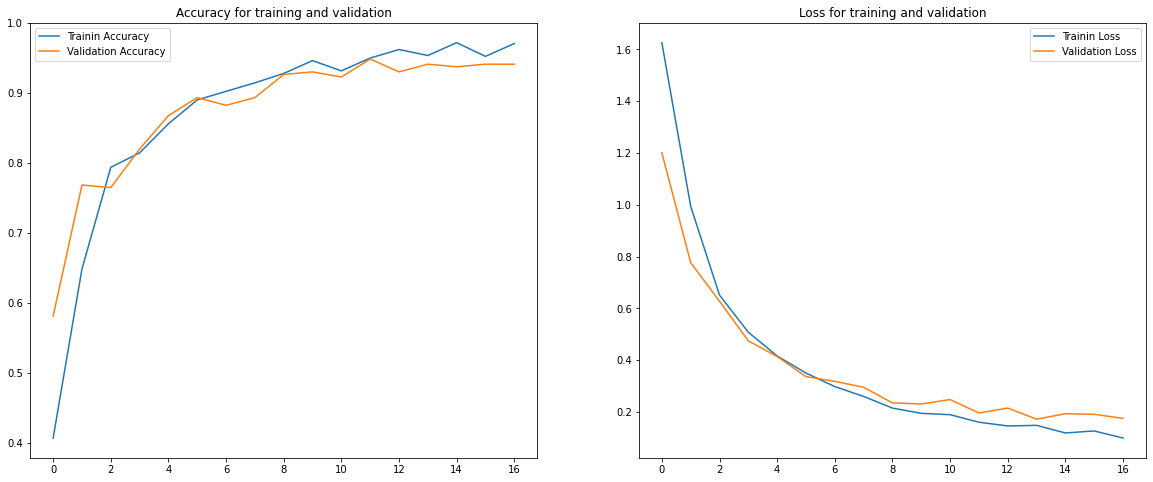

In [8]:
plot_training_history(history)

In [9]:
_, baseline_accuracy = model.evaluate(testing_dataset, verbose = 0)
print('Accuracy: ', round(baseline_accuracy*100, 3), '%')

Accuracy:  90.909 %


In [10]:
model.save('saved_models/' + MODEL_NAME + '.keras')

9/9 [==============================] - 3s 232ms/step


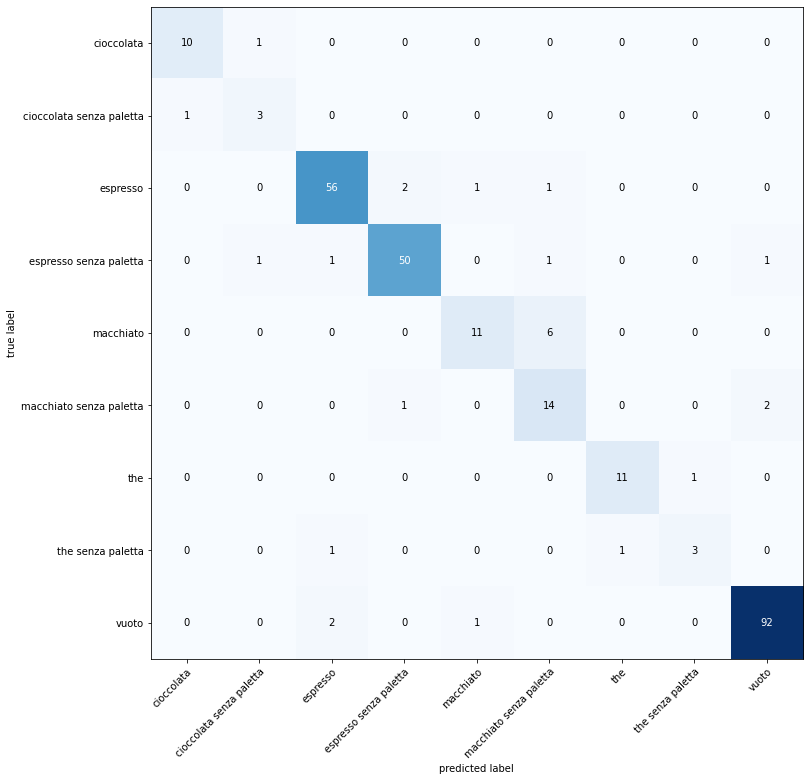

In [11]:
plotting_confusion_matrix(testing_dataset, model, class_names)

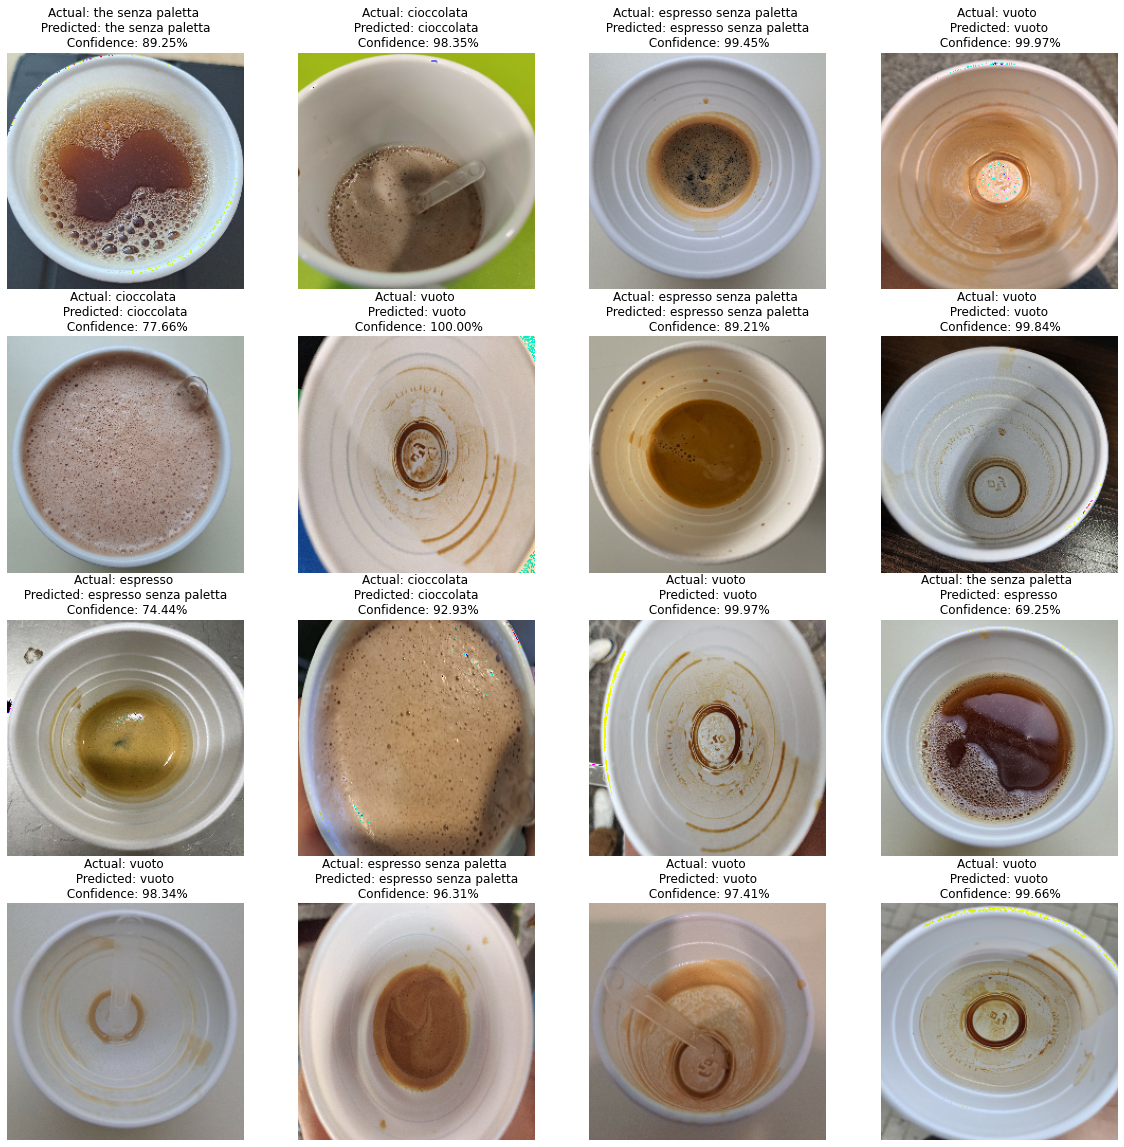

In [12]:
plot_test_images(model, testing_dataset, class_names, num_images = 16, scaling = SCALE, offset=OFFSET)